In [66]:
!pip install pykalman

In [39]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from math import sqrt

from pykalman import KalmanFilter
from sklearn.linear_model import Ridge
from statsmodels.tsa.stattools import adfuller


In [67]:
import yfinance as yf
import pandas as pd

# Download data
msft_raw = yf.download("MSFT", start="2015-01-01", end="2024-01-01")

# ALWAYS handle MultiIndex safely
if isinstance(msft_raw.columns, pd.MultiIndex):
    # Select MSFT ticker level
    msft_raw = msft_raw.xs('MSFT', level=1, axis=1)

# Now columns are guaranteed to be single-level:
# ['Open', 'High', 'Low', 'Close', 'Volume']

# Use adjusted close (Close is already adjusted)
msft = msft_raw[['Close']].copy()
msft.rename(columns={'Close': 'price'}, inplace=True)

msft.dropna(inplace=True)

print(msft.head())
print(msft.columns)


/tmp/ipython-input-1712759613.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  msft_raw = yf.download("MSFT", start="2015-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed

Price           price
Date                 
2015-01-02  39.858459
2015-01-05  39.491920
2015-01-06  38.912270
2015-01-07  39.406693
2015-01-08  40.565941
Index(['price'], dtype='object', name='Price')


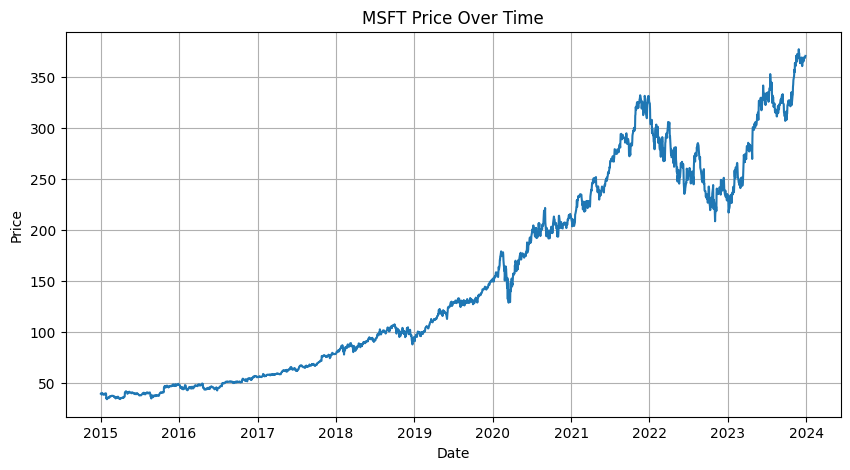

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(msft.index, msft['price'])
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("MSFT Price Over Time")
plt.grid(True)
plt.show()


In [69]:
import numpy as np
import pandas as pd

# --- RETURNS ---
# Log returns (stationary)
msft['log_return'] = np.log(msft['price'] / msft['price'].shift(1))
msft['lag_return'] = msft['log_return'].shift(1)

# --- MOVING AVERAGES ---
msft['ma_5']  = msft['price'].rolling(5).mean()
msft['ma_20'] = msft['price'].rolling(20).mean()
msft['ma_60'] = msft['price'].rolling(60).mean()

# --- MOMENTUM INDICATORS ---
# Rate of Change (ROC)
msft['roc_5'] = msft['price'].pct_change(5)

# Moving Average Crossover Momentum
msft['ma_momentum'] = msft['ma_5'] - msft['ma_20']

# --- VOLATILITY ---
# Rolling volatility (20-day)
msft['vol_20'] = msft['log_return'].rolling(20).std()

# --- VOLUME-BASED FEATURES (if volume exists) ---
if 'Volume' in msft.columns:
    msft['vol_ma_20'] = msft['Volume'].rolling(20).mean()
    msft['volume_change'] = msft['Volume'].pct_change()

# --- CLEAN DATA ---
msft.dropna(inplace=True)

print(msft.head())
print(msft.columns)


Price           price  log_return  lag_return       ma_5      ma_20  \
Date                                                                  
2015-03-30  35.162983   -0.000244   -0.005841  35.626553  36.157087   
2015-03-31  34.905437   -0.007351   -0.000244  35.241958  36.044627   
2015-04-01  34.956936    0.001474   -0.007351  35.114902  35.944185   
2015-04-02  34.587814   -0.010615    0.001474  34.956946  35.823141   
2015-04-06  35.669476    0.030794   -0.010615  35.056529  35.788373   

Price           ma_60     roc_5  ma_momentum    vol_20  
Date                                                    
2015-03-30  37.280290 -0.044330    -0.530534  0.013082  
2015-03-31  37.197739 -0.052214    -0.802669  0.012893  
2015-04-01  37.122156 -0.017849    -0.829283  0.012924  
2015-04-02  37.050082 -0.022324    -0.866196  0.013002  
2015-04-06  36.987795  0.014157    -0.731844  0.014622  
Index(['price', 'log_return', 'lag_return', 'ma_5', 'ma_20', 'ma_60', 'roc_5',
       'ma_momentum', 'v

In [70]:
from statsmodels.tsa.stattools import adfuller

def run_adf(series, name):

    result = adfuller(series.dropna())

    print(f"ADF Test on {name}")
    print(f"p-value       : {result[1]:.4f}")

    if result[1] < 0.05:
        print("Conclusion    : Series is stationary (Reject H0)")
    else:
        print("Conclusion    : Series is non-stationary (Fail to Reject H0)")

    print("-" * 50)


# Run ADF tests
run_adf(msft['price'], "MSFT Price")
run_adf(msft['log_return'], "MSFT Log Returns")


ADF Test on MSFT Price
p-value       : 0.9898
Conclusion    : Series is non-stationary (Fail to Reject H0)
--------------------------------------------------
ADF Test on MSFT Log Returns
p-value       : 0.0000
Conclusion    : Series is stationary (Reject H0)
--------------------------------------------------


In [87]:
from pykalman import KalmanFilter

def KalmanFilterTrend(price):
    n = len(price)
    t = np.arange(n)/n

    obs_mat = np.vstack([np.ones(n), t]).T[:, np.newaxis]

    delta = 1e-4
    trans_cov = delta / (1 - delta) * np.eye(2)

    kf = KalmanFilter(
        n_dim_obs=1,
        n_dim_state=2,
        initial_state_mean=[price.iloc[0], 0],
        initial_state_covariance=np.eye(2),
        transition_matrices=np.eye(2),
        observation_matrices=obs_mat,
        observation_covariance=1,
        transition_covariance=trans_cov
    )

    state_means, _ = kf.filter(price.values)
    return state_means[:, 0], state_means[:, 1]

msft['fair_value'], msft['trend'] = KalmanFilterTrend(msft['price'])
msft['deviation'] = msft['price'] - msft['fair_value']


In [88]:
features = ['lag_return', 'roc_5', 'vol_20']
X = msft[features].values
y = msft['log_return'].values

kf_reg = KalmanFilter(
    transition_matrices=np.eye(len(features)),
    observation_matrices=X[:, np.newaxis, :],
    initial_state_mean=np.zeros(len(features)),
    initial_state_covariance=np.eye(len(features)),
    transition_covariance=0.001 * np.eye(len(features)),
    observation_covariance=0.01
)

state_means, _ = kf_reg.filter(y)


In [89]:
from sklearn.linear_model import Ridge

# Features and target (time-aligned)
X_ml = state_means[:-1]
y_ml = y[1:]

# Train model
model = Ridge(alpha=1.0)
model.fit(X_ml, y_ml)

# ---- CRITICAL FIX: align msft to feature length ----
n = len(X_ml)
msft = msft.iloc[-n:].copy()

# Add predictions
msft['predicted_return'] = model.predict(X_ml)


In [90]:
threshold = 0.001

msft['signal'] = 0
msft.loc[msft['predicted_return'] > threshold, 'signal'] = 1
msft.loc[msft['predicted_return'] < -threshold, 'signal'] = -1


In [97]:
from math import sqrt

def backtest(price, signal):
    df = pd.DataFrame({'price': price})
    df['signal'] = signal

    df['returns'] = df['price'].pct_change()
    df['strategy_returns'] = df['signal'].shift(1) * df['returns']

    df['cum_strategy'] = (1 + df['strategy_returns']).cumprod()
    df['cum_buy_hold'] = (1 + df['returns']).cumprod()
    df['trade'] = df['signal'].diff().abs()
    cost = 0.0005  # 5 bps
    df['strategy_returns'] = (df['signal'].shift(1) * df['returns']- df['trade'] * cost)

    sharpe = sqrt(252) * df['strategy_returns'].mean() / df['strategy_returns'].std()
    drawdown = (df['cum_strategy'] - df['cum_strategy'].cummax()) / df['cum_strategy'].cummax()

    return df, sharpe, drawdown.min()

results, sharpe, max_dd = backtest(msft['price'], msft['signal'])

print("Sharpe Ratio:", sharpe)
print("Max Drawdown:", max_dd)


Sharpe Ratio: 0.8098117579300239
Max Drawdown: -0.35540837894443505


In [98]:
wins = results['strategy_returns'][results['strategy_returns'] > 0].count()
losses = results['strategy_returns'][results['strategy_returns'] < 0].count()
win_loss_ratio = wins / losses if losses != 0 else np.nan

print("Win/Loss Ratio:", win_loss_ratio)


Win/Loss Ratio: 1.0039164490861618


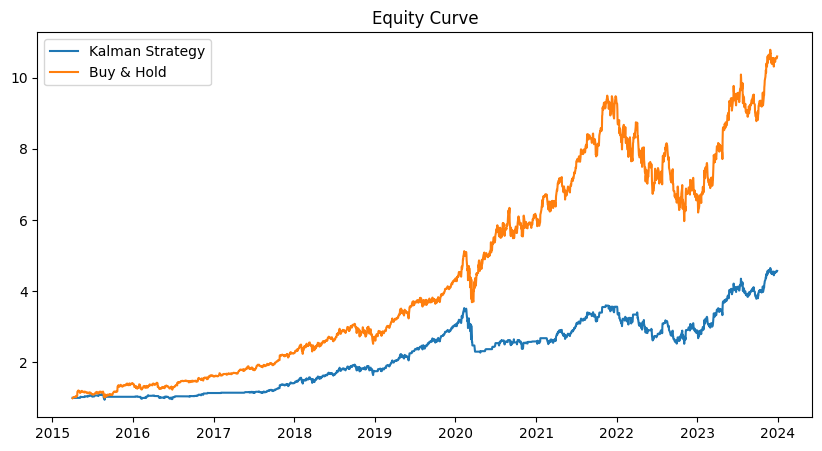

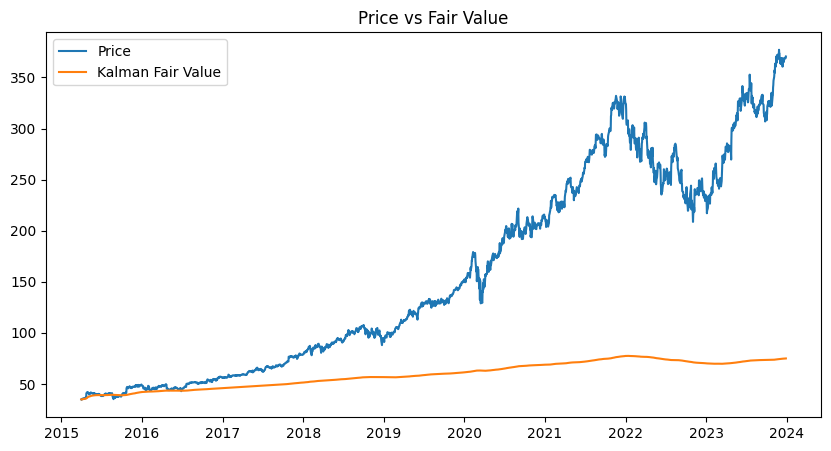

In [99]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(results['cum_strategy'], label='Kalman Strategy')
plt.plot(results['cum_buy_hold'], label='Buy & Hold')
plt.legend()
plt.title("Equity Curve")
plt.show()

plt.figure(figsize=(10,5))
plt.plot(msft['price'], label='Price')
plt.plot(msft['fair_value'], label='Kalman Fair Value')
plt.legend()
plt.title("Price vs Fair Value")
plt.show()


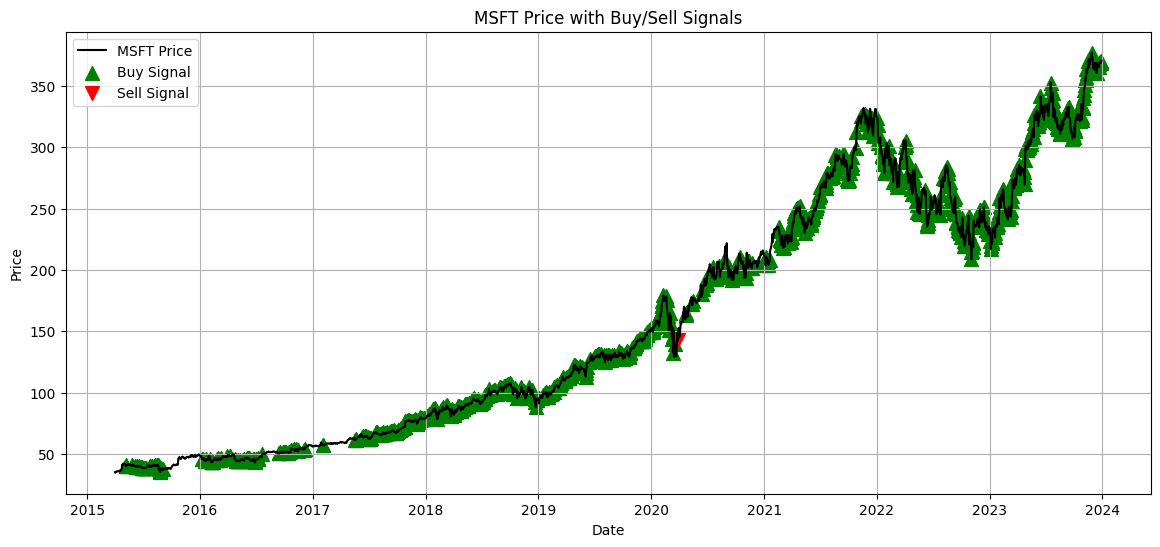

In [100]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))

# Plot price
plt.plot(msft.index, msft['price'], label='MSFT Price', color='black')

# Buy signals
plt.scatter(
    msft.index[msft['signal'] == 1],
    msft['price'][msft['signal'] == 1],
    color='green',
    label='Buy Signal',
    marker='^',
    s=100
)

# Sell signals
plt.scatter(
    msft.index[msft['signal'] == -1],
    msft['price'][msft['signal'] == -1],
    color='red',
    label='Sell Signal',
    marker='v',
    s=100
)

plt.title("MSFT Price with Buy/Sell Signals")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)

plt.show()
